In [1]:
# IDT Color Transfer – Assignment Version
# Based on Pitié et al. (2007)

import numpy as np
from scipy.interpolate import interp1d
from PIL import Image
import matplotlib.pyplot as plt
import os
from scipy.stats import rankdata
from scipy.interpolate import interp1d

def compute_rotation_matrix(dim=3):
    """Generates a random orthonormal rotation matrix."""
    Q, _ = np.linalg.qr(np.random.randn(dim, dim))
    return Q

def match_1d_cdf(source, target):
    """1D histogram matching via inverse CDF."""
    s_sorted = np.sort(source)
    t_sorted = np.sort(target)
    # Normalized cumulative indices (CDF)
    s_cdf = np.linspace(0, 1, len(s_sorted))
    t_cdf = np.linspace(0, 1, len(t_sorted))

    # Interpolated inverse CDF of target
    inv_cdf = interp1d(t_cdf, t_sorted, bounds_error=False, fill_value=(t_sorted[0], t_sorted[-1]))

    # Map source to percentile and apply inverse target CDF
    source_ranks = rankdata(source, method='average') / len(source)
    return inv_cdf(source_ranks)

def iterative_distribution_transfer(source, target, iterations=10):
    """
    Perform iterative distribution transfer (IDT) to match the color distribution
    of the source image to that of the target.
    """
    u = source.copy()
    for _ in range(iterations):
        R = compute_rotation_matrix(u.shape[1])
        u_rot = u @ R.T
        v_rot = target @ R.T
        for i in range(u.shape[1]):
            u_rot[:, i] = match_1d_cdf(u_rot[:, i], v_rot[:, i])
        u = u_rot @ R  # Transform back
    return u

# apply use
def apply_color_transfer(source_img, target_img, iterations=10):
    """Apply IDT color transfer on two images."""
    src_flat = source_img.reshape(-1, 3).astype(np.float32)
    tgt_flat = target_img.reshape(-1, 3).astype(np.float32)
    src_transferred = iterative_distribution_transfer(src_flat, tgt_flat, iterations)
    return np.clip(src_transferred.reshape(source_img.shape), 0, 255).astype(np.uint8)




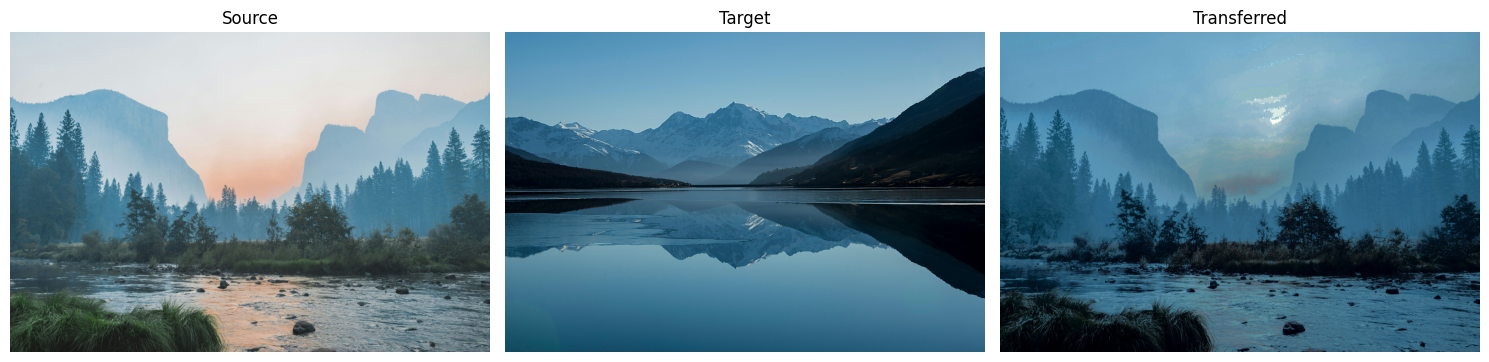

In [2]:
import matplotlib.pyplot as plt
import numpy as np

source = plt.imread('imgs/adip-im1.jpg')
target = plt.imread('imgs/adip-im2.jpg')

result = apply_color_transfer(source, target, iterations=10)

plt.figure(figsize=(15, 5))
for i, img, title in zip(range(1, 4), [source, target, result], ["Source", "Target", "Transferred"]):
    plt.subplot(1, 3, i)
    plt.imshow(np.clip(img / 255, 0, 1))  # Normalize for display
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()


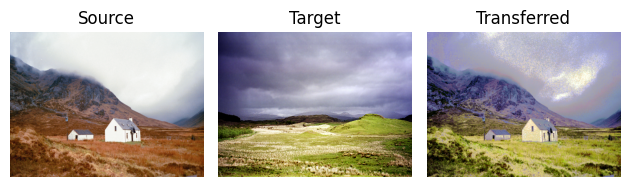

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --------- test on images from paper ------

source2 = plt.imread('imgs/scotland_house.png')[..., :3]
target2 = plt.imread('imgs/scotland_plain.png')[..., :3]

if source2.max() <= 1.0: source2 *= 255
if target2.max() <= 1.0: target2 *= 255

result2 = apply_color_transfer(source2.astype(np.float32), target2.astype(np.float32), iterations=10)

for i, (img, title) in enumerate(zip([source2, target2, result2], ["Source", "Target", "Transferred"]), 1):
    plt.subplot(1, 3, i)
    plt.imshow(np.clip(img / 255, 0, 1))
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
from scipy.stats import gaussian_kde, entropy

# code ff aanpassen zodat hij KL kan bijhouden

def run_idt(source, target, num_iters=20, record_intermediate=True):
    u = source.copy()
    trajectory = [u.copy()] if record_intermediate else None

    for _ in range(num_iters):
        R = compute_rotation_matrix(u.shape[1])
        u_rot = u @ R.T
        v_rot = target @ R.T
        for i in range(u.shape[1]):
            u_rot[:, i] = match_1d_cdf(u_rot[:, i], v_rot[:, i])
        u = u_rot @ R
        if record_intermediate:
            trajectory.append(u.copy())

    return u, trajectory

 # plot 2D probability density contours (Fig A.1 style)


def plot_idt_pdf():
    np.random.seed(0)
    N = 1000
    src = np.vstack([np.random.multivariate_normal([80, 80], [[800, 0], [0, 800]], N//2),
                     np.random.multivariate_normal([180, 180], [[800, 0], [0, 800]], N//2)])
    tgt = np.vstack([np.random.multivariate_normal([120, 160], [[800, 0], [0, 800]], N//2),
                     np.random.multivariate_normal([160, 60], [[800, 0], [0, 800]], N//2)])

    # Run IDT and store trajectory
    _, traj = run_idt(src, tgt, num_iters=20, record_intermediate=True)

    # Precompute 2D KDE for target on a fixed grid
    grid_x, grid_y = np.meshgrid(
        np.linspace(0, 255, 100),
        np.linspace(0, 255, 100)
    )
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()])
    kde_tgt = gaussian_kde(tgt.T)(grid_points)

    # Compute symmetric KL divergence per step
    kl_values = []
    for step in traj:
        kde_src = gaussian_kde(step.T)(grid_points)
        p = kde_src / np.sum(kde_src)
        q = kde_tgt / np.sum(kde_tgt)
        kl = 0.5 * (entropy(p, q) + entropy(q, p))
        kl_values.append(kl)

    # Plot
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    steps = [tgt, traj[0], traj[1], traj[2], traj[3], traj[4], traj[6], traj[-1]]
    titles = ["Target", "Original", "Iter 1", "Iter 2", "Iter 3", "Iter 4", "Iter 6", f"Iter {len(traj)-1}"]

    for ax, data, title in zip(axs.flat[:8], steps, titles):
        kde = gaussian_kde(data.T)
        x, y = np.meshgrid(*[np.linspace(data[:, i].min()-10, data[:, i].max()+10, 100) for i in [0, 1]])
        z = kde(np.vstack([x.ravel(), y.ravel()])).reshape(x.shape)
        ax.contour(x, y, z, levels=10, cmap="cool")
        ax.set_title(title)
        ax.axis('off')
        ax.set_aspect('equal')

    # Final subplot: KL divergence plot
    axs.flat[8].plot(range(len(kl_values)), kl_values, marker='o')
    axs.flat[8].set_title("KL divergence")
    axs.flat[8].set_xlabel("Iteration")
    axs.flat[8].set_ylabel("KL")

    plt.tight_layout()
    plt.show()


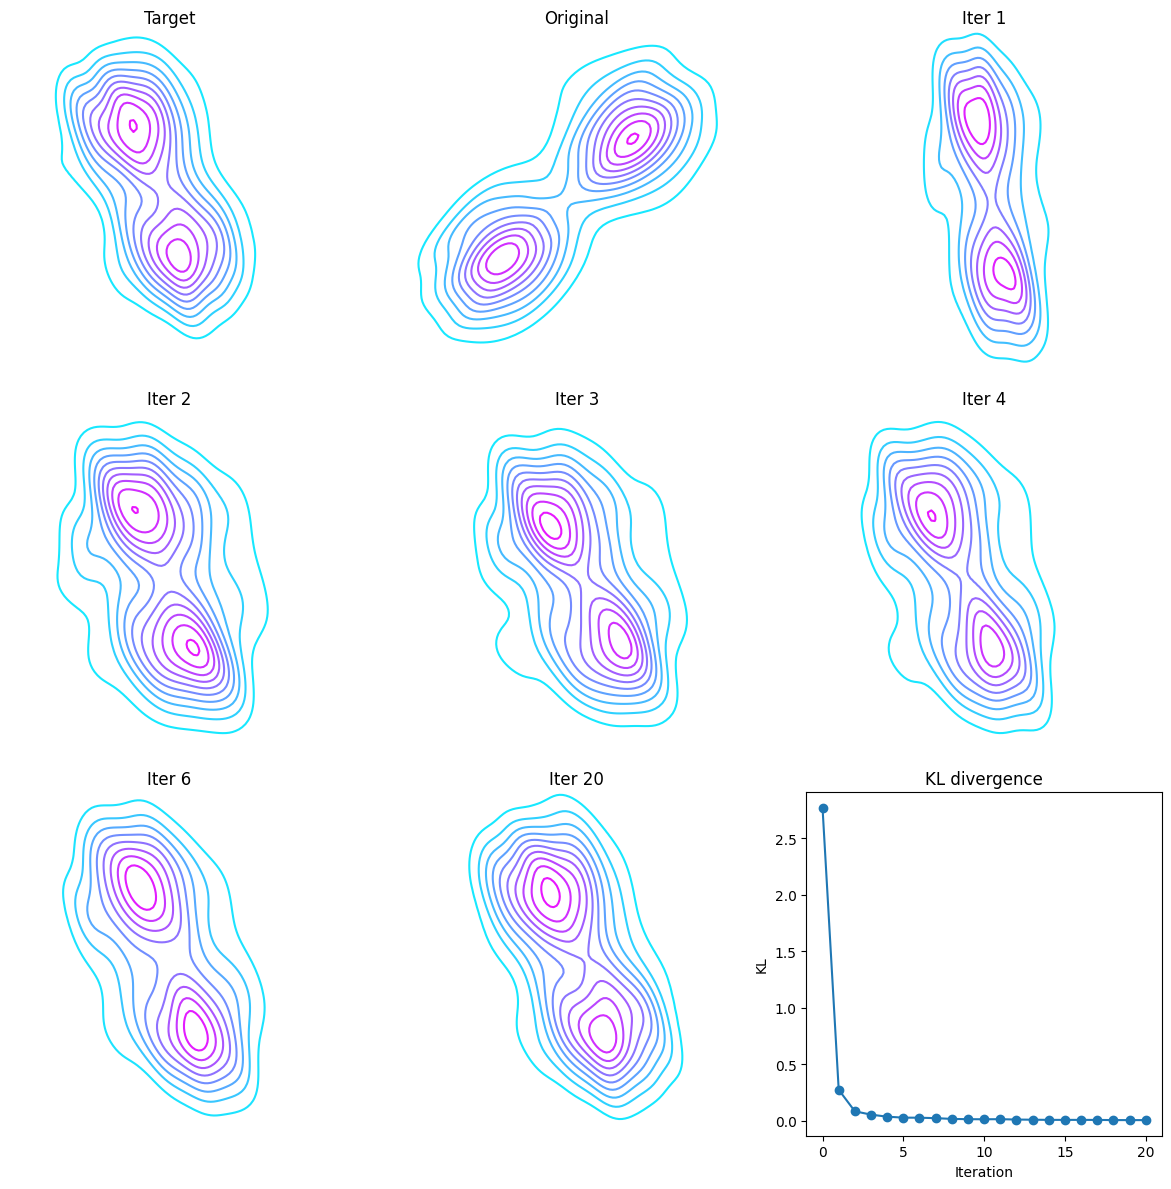

In [5]:
plot_idt_pdf()

In [6]:
import cv2


def poisson_regrain_gauss_seidel(original, transferred, num_iters=100):
    h, w = original.shape[:2]
    J = np.zeros_like(original, dtype=np.float32)

    for c in range(3):
        I = original[:, :, c]
        tI = transferred[:, :, c]

        # Compute gradient
        grad_x = cv2.Sobel(I, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(I, cv2.CV_32F, 0, 1, ksize=3)
        grad_I = np.sqrt(grad_x ** 2 + grad_y ** 2)

        phi = 30 / (1 + 10 * grad_I)
        psi = np.where(grad_I < 5, grad_I / 5, 1)

        # Shifted phi
        phi_up = np.zeros_like(phi)
        phi_up[1:] = phi[:-1]
        phi_down = np.zeros_like(phi)
        phi_down[:-1] = phi[1:]
        phi_left = np.zeros_like(phi)
        phi_left[:, 1:] = phi[:, :-1]
        phi_right = np.zeros_like(phi)
        phi_right[:, :-1] = phi[:, 1:]

        # Coefficients
        a1 = -(phi_up + phi) / 2
        a2 = -(phi_down + phi) / 2
        a3 = -(phi_left + phi) / 2
        a4 = -(phi_right + phi) / 2
        a5 = 0.5 * (4 * phi + phi_up + phi_down + phi_left + phi_right) + psi

        # Shifted I
        I_up = np.zeros_like(I)
        I_up[1:] = I[:-1]
        I_down = np.zeros_like(I)
        I_down[:-1] = I[1:]
        I_left = np.zeros_like(I)
        I_left[:, 1:] = I[:, :-1]
        I_right = np.zeros_like(I)
        I_right[:, :-1] = I[:, 1:]

        a6 = 0.5 * ((phi + phi_up) * (I_up - I) +
                    (phi + phi_down) * (I_down - I) +
                    (phi + phi_left) * (I_left - I) +
                    (phi + phi_right) * (I_right - I)) + psi * tI

        # Initial guess
        J_k = tI.copy()

        # Gauss-Seidel iterations
        for _ in range(num_iters):
            # Shifted J
            J_up = np.zeros_like(J_k)
            J_up[1:] = J_k[:-1]
            J_down = np.zeros_like(J_k)
            J_down[:-1] = J_k[1:]
            J_left = np.zeros_like(J_k)
            J_left[:, 1:] = J_k[:, :-1]
            J_right = np.zeros_like(J_k)
            J_right[:, :-1] = J_k[:, 1:]
            J_k[1:-1, 1:-1] = (1 / a5[1:-1, 1:-1]) * (
                a6[1:-1, 1:-1]
                - a1[1:-1, 1:-1] * J_k[0:-2, 1:-1]     # Up
                - a2[1:-1, 1:-1] * J_k[2:, 1:-1]       # Down
                - a3[1:-1, 1:-1] * J_k[1:-1, 0:-2]     # Left
                - a4[1:-1, 1:-1] * J_k[1:-1, 2:]       # Right
            )


            # Enforce Neumann BC: match gradient of I at the boundary
            # Top and bottom borders
            J_k[0, 1:-1]   = J_k[1, 1:-1]   + (I[0, 1:-1]   - I[1, 1:-1])
            J_k[-1, 1:-1]  = J_k[-2, 1:-1]  + (I[-1, 1:-1]  - I[-2, 1:-1])

            # Left and right borders
            J_k[1:-1, 0]   = J_k[1:-1, 1]   + (I[1:-1, 0]   - I[1:-1, 1])
            J_k[1:-1, -1]  = J_k[1:-1, -2]  + (I[1:-1, -1]  - I[1:-1, -2])


        J[:, :, c] = J_k

    return J


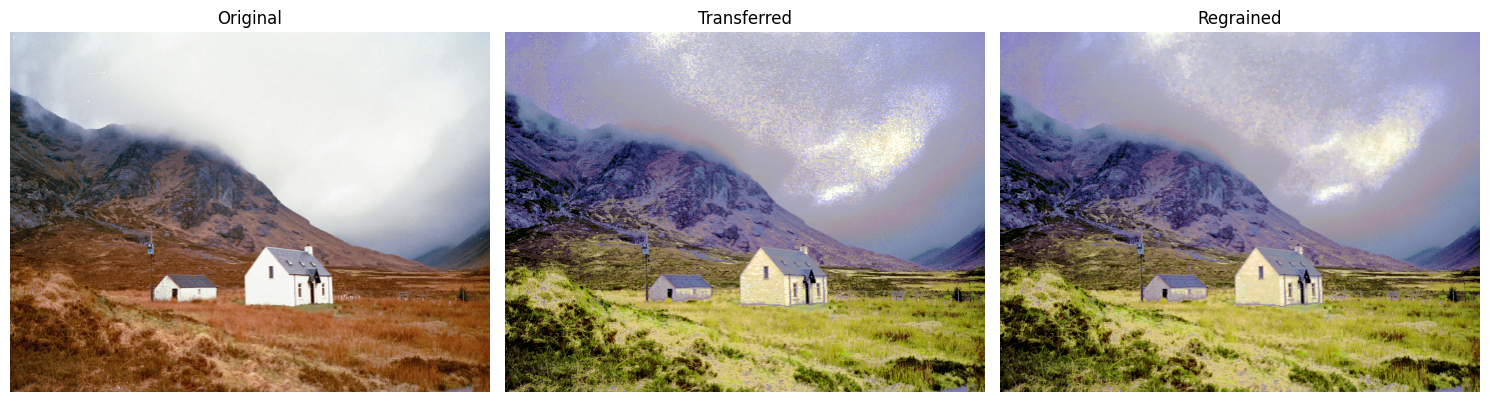

In [12]:
regrained = poisson_regrain_gauss_seidel(source2, result2, num_iters=100)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(
    zip([source2, result2, regrained], ["Original", "Transferred", "Regrained"]), 1):
    plt.subplot(1, 3, i)
    plt.imshow(np.clip(img / 255.0, 0, 1))
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()




In [11]:
import numpy as np
import cv2

def poisson_regrain_gauss_seidel(original, transferred, num_iters=100):
    h, w = original.shape[:2]
    J = np.zeros_like(original, dtype=np.float32)

    for c in range(3):
        I = original[:, :, c].astype(np.float32)
        tI = transferred[:, :, c].astype(np.float32)

        # Compute gradients and weights
        grad_x = cv2.Sobel(I, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(I, cv2.CV_32F, 0, 1, ksize=3)
        grad_I = np.sqrt(grad_x ** 2 + grad_y ** 2)

        phi = 30 / (1 + 10 * grad_I)
        psi = np.where(grad_I < 5, grad_I / 5, 1)

        # Shifted phi
        phi_up = np.pad(phi[:-1, :], ((1, 0), (0, 0)), mode='edge')
        phi_down = np.pad(phi[1:, :], ((0, 1), (0, 0)), mode='edge')
        phi_left = np.pad(phi[:, :-1], ((0, 0), (1, 0)), mode='edge')
        phi_right = np.pad(phi[:, 1:], ((0, 0), (0, 1)), mode='edge')

        # Coefficients
        a1 = -(phi_up + phi) / 2
        a2 = -(phi_down + phi) / 2
        a3 = -(phi_left + phi) / 2
        a4 = -(phi_right + phi) / 2
        a5 = 0.5 * (4 * phi + phi_up + phi_down + phi_left + phi_right) + psi

        # Shifted I
        I_up = np.pad(I[:-1, :], ((1, 0), (0, 0)), mode='edge')
        I_down = np.pad(I[1:, :], ((0, 1), (0, 0)), mode='edge')
        I_left = np.pad(I[:, :-1], ((0, 0), (1, 0)), mode='edge')
        I_right = np.pad(I[:, 1:], ((0, 0), (0, 1)), mode='edge')

        a6 = -0.5 * ((phi + phi_up) * (I_up - I) +
                    (phi + phi_down) * (I_down - I) +
                    (phi + phi_left) * (I_left - I) +
                    (phi + phi_right) * (I_right - I)) + psi * tI

        # Initial guess
        J_k = tI.copy()

        # Gauss-Seidel iterations (interior only)
        for _ in range(num_iters):
            J_new = J_k.copy()

            J_new[1:-1, 1:-1] = (1 / a5[1:-1, 1:-1]) * (
                a6[1:-1, 1:-1]
                - a1[1:-1, 1:-1] * J_k[0:-2, 1:-1]
                - a2[1:-1, 1:-1] * J_k[2:, 1:-1]
                - a3[1:-1, 1:-1] * J_k[1:-1, 0:-2]
                - a4[1:-1, 1:-1] * J_k[1:-1, 2:]
            )

            # Neumann BCs to preserve I's gradient at edges
            J_new[0, 1:-1] = J_new[1, 1:-1] + (I[0, 1:-1] - I[1, 1:-1])
            J_new[-1, 1:-1] = J_new[-2, 1:-1] + (I[-1, 1:-1] - I[-2, 1:-1])
            J_new[1:-1, 0] = J_new[1:-1, 1] + (I[1:-1, 0] - I[1:-1, 1])
            J_new[1:-1, -1] = J_new[1:-1, -2] + (I[1:-1, -1] - I[1:-1, -2])

            # Optional: Clamp to image range
            J_k = np.clip(J_new, 0, 255)

        J[:, :, c] = J_k

    return J.astype(np.uint8)
